# AMBA Batch 15 - Big Data Management 2 Group Assignment

### Submission by:

* **Deep Kamal Singh** - 12020053
* **Ila Barshilia**    - 12020022
* **Mohua Sinha**      - 12020015

**Date** - ***04-May-2021***

## Loading pyspark libraries

This step will not be needed in databricks environment, however for Google Colab,or local Jupyter notebook, we must ensure pyspark packages are installed


In [2]:
!pip install pyspark

     |████████████████████████████████| 212.3MB 69kB/s 
     |████████████████████████████████| 204kB 48.6MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=f23acc2183c52f1a404097fb503b29bbf771ea041bdedf17b2b9fad894d34d2f
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


## Loading libraries needed for analysis and visualizaton

In [3]:
!pip install abc-analysis
!pip install seaborn
!pip install inventorize3

  Created wheel for inventorize3: filename=inventorize3-0.0.1-cp37-none-any.whl size=15604 sha256=92bfee170bdf2c005a0af603529761ebe260a12c909afd197271a1bdf2f454e0
  Stored in directory: /root/.cache/pip/wheels/93/23/26/049c7e680d90eb2ba68c1fc1b5704a3c7cb65566f4f4742036
Successfully built inventorize3


# Problem Statement


*  Correlation between Sensex close/volume and covid cases - interpret 
effect of  first & second wave and lockdown measures. How long did it take for stock market to recover after there was a declining trend in cases. Supplement with covid lockdown relaxation data.
*   ABC Analysis - top states containing most of the cases,  top districts containing most of the cases
*   Heat Map of cases with states/UT and time
*   Time series analysis of stock market and covid data 




# Business Understanding

Intuitively we know, Covid cases across the world had a significant impact on businesses as countries were under lockdown and due to very less economic activity, stock markets plummeted. In this assignment, we want to quantify the impact covid had on stock market, when stocks started recovering, effect of lockdown and second wave. 
Considering this problem at hand, we are using 2 APIs to get live covid and stocks data which refreshes every day. After data collection and pre-processing, we will aggregate data and create several pipelines to perform historical data analysis, time series and pareto analysis.
This anaylytics has huge importance from investors' perspective, identifying valleys in sensex data and making investment choices can be great from economical point of view.

Reason behind choosing BSE Sensex - BSE Sensex is free float market weighted stock market index of 30 companies which often indicate very well overall market sway. Hence, we decided to go ahead with sensex as index to compare with covid data.
<hr/>

# Benchmarking

We referred to [Official Benchmarks](http://sortbenchmark.org/) of Apache Spark and comparative stats from other big data platforms, 
as its apparent that Apache Spark leads the way, we decided to use this platform for our project.

Further, we analysed our Business understanding and problem statements to conclude that for given time period of 15 months, our data size will not exceed more than 1 million rows, 

we ran our pipelines on below platforms
 * Local - 32GB, 24 (16+8) Cores, Core i9 , Apache Spark 3.1.1
 * Databricks community environment - 15.25GB, 2 vCores
 * Google Colab environment - Random allocation of runtimes

We find that the most performant environment is local setup. The Google Colaboratory allocates runtime randomly and sometime higher performance machines are allocated, and at times lower capacity machines are allocated, on the other hand with Databricks community account we get performance of 2 vCores and 15.25GB Memory, 

Looking from collaboration point of view and ease of use (no need to create clusters everytime) we decided to work with Google Colab.

<hr/>

# Data Source Selection


## RAW Data Source for Covid

* https://api.covid19india.org/csv/latest/raw_data`{file_index}`.csv : 
     - `file_index` ranges from 1 to 26
     - These files contain historical data about covid spread in India since 31st Jan 2020
     - While the file index from 1 to 25 contain historical record, the file 26 is live file updated with Covid records per day after 1st April 2021


## Data Source 2

**Original Source**: https://in.finance.yahoo.com/quote/%5EBSESN/history?period1=1577836800&period2=1619049600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

  - We copied the data from Yahoo Finance for BSE sensex and saved it in a CSV file on Google drive location

**Cached** : https://docs.google.com/spreadsheets/d/1sNXNbIrOSU6jdJwFHOY6FGGM8PsJrNdkWf_70WOPtjc/export?format=csv

<hr/>


### Setup

In [4]:
from pyspark import SparkConf, SparkContext,SparkFiles
from pyspark.sql import *


config_prefix = "ampba.batch15.bdm2.group_assignment"

spark = SparkSession.builder \
.master("local") \
.appName("BDM2-GroupAssignment") \
.config(config_prefix+".raw_covid_datasource", "https://api.covid19india.org/csv/latest/raw_data{file_index}.csv") \
.config(config_prefix+".raw_covid_datasource_file_upto", 26) \
.config(config_prefix+".covid_datasource", "https://api.covid19india.org/csv/latest/districts.csv") \
.config(config_prefix+".stock_datasource", "https://docs.google.com/spreadsheets/d/1sNXNbIrOSU6jdJwFHOY6FGGM8PsJrNdkWf_70WOPtjc/export?format=csv") \
.getOrCreate()


In [5]:
spark

# Data Collection and Pre-processing

## Loading / Landing Zone

Loading data from RAW data sources - Using `SparkFile` for reading each RAW file - and save records in `raw_data_store`


In [6]:
raw_data_stores=[]
def fetch_and_load_raw_data(f_now,file_index):
    print("Fetching data from",f_now,"...")
    spark.sparkContext.addFile(f_now)
    print("File loaded, now adding in Dataframe...")    
    return spark.read.option("header", "true").csv(SparkFiles.get("raw_data{file_index}.csv".format(file_index=file_index)))

print("Fetching first raw data file")

f_now = spark.sparkContext.getConf().get(config_prefix+'.raw_covid_datasource').format(file_index=1)

raw_data_stores.append(fetch_and_load_raw_data(f_now,1))

for file_index in range(2, 1+int(spark.sparkContext.getConf().get(config_prefix+'.raw_covid_datasource_file_upto'))):
    f_now = spark.sparkContext.getConf().get(config_prefix+'.raw_covid_datasource').format(file_index=file_index)  
    raw_data_stores.append(fetch_and_load_raw_data(f_now,file_index))

Fetching first raw data file
Fetching data from https://api.covid19india.org/csv/latest/raw_data1.csv ...
File loaded, now adding in Dataframe...
Fetching data from https://api.covid19india.org/csv/latest/raw_data2.csv ...
File loaded, now adding in Dataframe...
Fetching data from https://api.covid19india.org/csv/latest/raw_data3.csv ...
File loaded, now adding in Dataframe...
Fetching data from https://api.covid19india.org/csv/latest/raw_data4.csv ...
File loaded, now adding in Dataframe...
Fetching data from https://api.covid19india.org/csv/latest/raw_data5.csv ...
File loaded, now adding in Dataframe...
Fetching data from https://api.covid19india.org/csv/latest/raw_data6.csv ...
File loaded, now adding in Dataframe...
Fetching data from https://api.covid19india.org/csv/latest/raw_data7.csv ...
File loaded, now adding in Dataframe...
Fetching data from https://api.covid19india.org/csv/latest/raw_data8.csv ...
File loaded, now adding in Dataframe...
Fetching data from https://api.covi

### Observing Schema of the raw data

In [7]:
raw_data_stores[0].printSchema()

root
 |-- Patient Number: string (nullable = true)
 |-- State Patient Number: string (nullable = true)
 |-- Date Announced: string (nullable = true)
 |-- Estimated Onset Date: string (nullable = true)
 |-- Age Bracket: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Detected City: string (nullable = true)
 |-- Detected District: string (nullable = true)
 |-- Detected State: string (nullable = true)
 |-- State code: string (nullable = true)
 |-- Current Status: string (nullable = true)
 |-- Notes: string (nullable = true)
 |-- Contracted from which Patient (Suspected): string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Type of transmission: string (nullable = true)
 |-- Status Change Date: string (nullable = true)
 |-- Source_1: string (nullable = true)
 |-- Source_2: string (nullable = true)
 |-- Source_3: string (nullable = true)
 |-- Backup Notes: string (nullable = true)
 |-- Num Cases: string (nullable = true)



### Merging all raw data into one, and selecting columns of our interest

**Columns of Interest**

   - Date Announced
   - Detected State
   - Detected District
   - Gender
   - Age Bracket
   - Detected City
   - Nationality
   - Current Status
   - Status Change Date
   - Num Cases

**We have loaded all the RAW data, now :** 
1. We will select only columns of our interest for each data set
2. Merge data in single Data Frame 



In [8]:
#Merging data

cols_of_interest=['Date Announced','Detected State','Detected District','Gender','Age Bracket','Detected City','Nationality','Current Status','Status Change Date','Num Cases']

merged_data =raw_data_stores[0].select(cols_of_interest)
for i in range(1,len(raw_data_stores)):
    print("Merging raw data file",1+i)
    df = raw_data_stores[i].select(cols_of_interest)
    print("Obtained rows",df.count())
    merged_data=merged_data.union(df)

Merging raw data file 2
Obtained rows 10819
Merging raw data file 3
Obtained rows 10020
Merging raw data file 4
Obtained rows 18231
Merging raw data file 5
Obtained rows 20488
Merging raw data file 6
Obtained rows 23423
Merging raw data file 7
Obtained rows 22770
Merging raw data file 8
Obtained rows 22808
Merging raw data file 9
Obtained rows 26897
Merging raw data file 10
Obtained rows 23112
Merging raw data file 11
Obtained rows 29045
Merging raw data file 12
Obtained rows 22334
Merging raw data file 13
Obtained rows 24252
Merging raw data file 14
Obtained rows 27583
Merging raw data file 15
Obtained rows 27346
Merging raw data file 16
Obtained rows 26625
Merging raw data file 17
Obtained rows 27286
Merging raw data file 18
Obtained rows 24636
Merging raw data file 19
Obtained rows 25384
Merging raw data file 20
Obtained rows 26310
Merging raw data file 21
Obtained rows 25496
Merging raw data file 22
Obtained rows 25791
Merging raw data file 23
Obtained rows 24549
Merging raw data f

**Importing Pyspark SQL functions from libraries**

In [9]:
import pyspark.sql.functions as fns
from pyspark.sql.functions import col
from pyspark.sql.functions import to_date
from pyspark.sql.types import StringType,BooleanType,DateType,IntegerType
from datetime import datetime
import pandas as pd

# EDA and Data quality report

### Data readiness
Converting the data types of relevant columns, and renaming columns to usable names

In [10]:
# Applying data type casting

merged_data_1=merged_data.select([to_date("Date Announced","dd/MM/yyyy").alias('Date'),
                                  col('Detected State').alias('State'),
                                  col('Detected District').alias('District'),
                                  'Gender',
                                  col('Age Bracket').alias('Age').cast(IntegerType()),
                                  col('Detected City').alias('City'),
                                  'Nationality',
                                  col('Current Status').alias('Status'),
                                  to_date('Status Change Date',"dd/MM/yyyy").alias('Status_Date'),
                                  col('Num Cases').alias('cases').cast(IntegerType())])


In [11]:
merged_data_1.show()


+----------+---------+----------+------+----+--------------------+-----------+------------+-----------+-----+
|      Date|    State|  District|Gender| Age|                City|Nationality|      Status|Status_Date|cases|
+----------+---------+----------+------+----+--------------------+-----------+------------+-----------+-----+
|2020-01-30|   Kerala|  Thrissur|     F|  20|            Thrissur|      India|   Recovered| 2020-02-14|    1|
|2020-02-02|   Kerala| Alappuzha|  null|null|           Alappuzha|      India|   Recovered| 2020-02-14|    1|
|2020-02-03|   Kerala| Kasaragod|  null|null|           Kasaragod|      India|   Recovered| 2020-02-14|    1|
|2020-03-02|    Delhi|East Delhi|     M|  45|East Delhi (Mayur...|      India|   Recovered| 2020-03-15|    1|
|2020-03-02|Telangana| Hyderabad|     M|  24|           Hyderabad|      India|   Recovered| 2020-03-02|    1|
|2020-03-03|Rajasthan|  Italians|     M|  69|              Jaipur|      Italy|   Recovered| 2020-03-03|    1|
|2020-03-0

## De-Normalizing Status column to consolidate count - using `DataFrame.pivot`

The status column contains various status in String format ~ Catagorical data, based on which we will pivot the table to keep relevant columns and counts of each status



In [12]:
pivoted_data=merged_data_1.withColumn('Status',fns.lower(col('Status'))).groupBy(["Date","State","District"]).pivot("Status").agg({"Cases":'sum'})


In [13]:
pivoted_data.printSchema()

root
 |-- Date: date (nullable = true)
 |-- State: string (nullable = true)
 |-- District: string (nullable = true)
 |-- null: long (nullable = true)
 |-- deceased: long (nullable = true)
 |-- hospitalized: long (nullable = true)
 |-- migrated: long (nullable = true)
 |-- migrated_other: long (nullable = true)
 |-- recovered: long (nullable = true)



## Preparing Data for Staging zone now

### Loading District Covid Data 

In [14]:
df_districts = pivoted_data.select(col('Date'),
                                   col('State'),
                                   col('District'),
                                   col('hospitalized').alias('Confirmed'),
                                   col('recovered').alias('Recovered'),
                                   col('deceased').alias('Deceased'))

df_districts = df_districts.filter(col('Confirmed').isNotNull() | col('Recovered').isNotNull() | col('Deceased').isNotNull())

We have removed those lines where none of the data is numeric - this cleans the entire data set as well
We can use either `filter` or `where`

In [15]:
df_districts=df_districts.withColumn('Confirmed', col('Confirmed').cast('integer'))\
                        .withColumn('Recovered', col('Recovered').cast('integer'))\
                        .withColumn('Deceased', col('Deceased').cast('integer'))

In [16]:
df_districts.printSchema()

root
 |-- Date: date (nullable = true)
 |-- State: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Confirmed: integer (nullable = true)
 |-- Recovered: integer (nullable = true)
 |-- Deceased: integer (nullable = true)



In [17]:
df_districts.select(["State","Confirmed","Recovered","Deceased"]).where(col("State").isNotNull()).groupBy("State").agg({'Confirmed':'sum','Recovered':'sum','Deceased':'sum'}).show(40,False)

+----------------------------------------+--------------+-------------+--------------+
|State                                   |sum(Recovered)|sum(Deceased)|sum(Confirmed)|
+----------------------------------------+--------------+-------------+--------------+
|Nagaland                                |12357         |115          |14717         |
|Karnataka                               |1209892       |16530        |1690862       |
|Odisha                                  |410192        |2141         |479751        |
|Kerala                                  |1338973       |5507         |1701919       |
|Dadra and Nagar Haveli and Daman and Diu|6541          |4            |8345          |
|Ladakh                                  |13019         |151          |14560         |
|State Unassigned                        |null          |null         |0             |
|Tamil Nadu                              |1108436       |14589        |1249285       |
|Chhattisgarh                            |6

In [18]:
#df_districts.head()
type(df_districts)

# print(df_districts.toPandas().max().T)
# print("\t")
# print( df_districts.toPandas().min().T)
df_districts.select(['Confirmed','Recovered','Deceased']).summary().show()

+-------+-----------------+------------------+-----------------+
|summary|        Confirmed|         Recovered|         Deceased|
+-------+-----------------+------------------+-----------------+
|  count|           207002|            172683|            56275|
|   mean|99.79734012231766| 98.05392540087907|4.004193691692581|
| stddev|465.4096633602333|442.97970033075364|11.80311483244228|
|    min|           -12822|            -11132|             -275|
|    25%|                5|                 5|                1|
|    50%|               16|                17|                2|
|    75%|               61|                61|                3|
|    max|            28395|             27421|              917|
+-------+-----------------+------------------+-----------------+



**Adding an integer format from date for better calculations** 

In [19]:
from datetime import datetime
from pyspark.sql.functions import date_format
df_districts=df_districts.withColumn("Effective_date",date_format(df_districts["Date"],"yyyyMMdd").cast(IntegerType()))

In [20]:
df_districts.show()

+----------+-----------------+-------------------+---------+---------+--------+--------------+
|      Date|            State|           District|Confirmed|Recovered|Deceased|Effective_date|
+----------+-----------------+-------------------+---------+---------+--------+--------------+
|2020-05-01|Jammu and Kashmir|          Baramulla|        1|        5|    null|      20200501|
|2020-06-25|    Uttar Pradesh|             Hardoi|     null|        5|    null|      20200625|
|2020-08-01|   Andhra Pradesh|            Kurnool|     1234|     1217|       6|      20200801|
|2020-10-17|    Uttar Pradesh|          Kaushambi|       16|       12|    null|      20201017|
|2020-10-25|      Uttarakhand|           Haridwar|       30|       26|    null|      20201025|
|2020-11-15|   Madhya Pradesh|        Hoshangabad|       17|        9|       1|      20201115|
|2020-12-14|Jammu and Kashmir|            Rajouri|        3|       10|    null|      20201214|
|2020-12-22|    Uttar Pradesh|Gautam Buddha Nagar|

# !!! Save to parquet table here

Partition the data based on date - so it's distributed and processed across all available cores.

In [21]:
from pyspark.sql.functions import col, countDistinct
df_districts.select(countDistinct('State')).show()

+---------------------+
|count(DISTINCT State)|
+---------------------+
|                   37|
+---------------------+



In [22]:
num_partitions=(df_districts.agg(countDistinct('State'))).head()[0]
df_districts = df_districts.repartition(num_partitions)
print(df_districts.rdd.getNumPartitions())

37


In [23]:
path="LZ_district_data"
#df_districts.repartition(col("State")).write.parquet(path, mode='overwrite').partitionBy(col("State"))
df_districts.write.mode('overwrite').parquet(path)

In [24]:
%cd /content/LZ_district_data
%ls

/content/LZ_district_data
part-00000-cd938287-7d8f-46ec-8b8d-f9b0714d256b-c000.snappy.parquet
part-00001-cd938287-7d8f-46ec-8b8d-f9b0714d256b-c000.snappy.parquet
part-00002-cd938287-7d8f-46ec-8b8d-f9b0714d256b-c000.snappy.parquet
part-00003-cd938287-7d8f-46ec-8b8d-f9b0714d256b-c000.snappy.parquet
part-00004-cd938287-7d8f-46ec-8b8d-f9b0714d256b-c000.snappy.parquet
part-00005-cd938287-7d8f-46ec-8b8d-f9b0714d256b-c000.snappy.parquet
part-00006-cd938287-7d8f-46ec-8b8d-f9b0714d256b-c000.snappy.parquet
part-00007-cd938287-7d8f-46ec-8b8d-f9b0714d256b-c000.snappy.parquet
part-00008-cd938287-7d8f-46ec-8b8d-f9b0714d256b-c000.snappy.parquet
part-00009-cd938287-7d8f-46ec-8b8d-f9b0714d256b-c000.snappy.parquet
part-00010-cd938287-7d8f-46ec-8b8d-f9b0714d256b-c000.snappy.parquet
part-00011-cd938287-7d8f-46ec-8b8d-f9b0714d256b-c000.snappy.parquet
part-00012-cd938287-7d8f-46ec-8b8d-f9b0714d256b-c000.snappy.parquet
part-00013-cd938287-7d8f-46ec-8b8d-f9b0714d256b-c000.snappy.parquet
part-00014-cd938287-7d

## **Staging Zone**

#### Reading  Districts data from Landing Zone





In [25]:
sc = spark.sparkContext

# using SQLContext to read parquet file
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
SZ_districts = sqlContext.read.parquet("LZ_district_data")

In [26]:
SZ_districts.show()

+----------+-----------------+-----------------+---------+---------+--------+--------------+
|      Date|            State|         District|Confirmed|Recovered|Deceased|Effective_date|
+----------+-----------------+-----------------+---------+---------+--------+--------------+
|2021-02-08|   Andhra Pradesh|     Vizianagaram|     null|        2|    null|      20210208|
|2020-09-16|    Uttar Pradesh|        Prayagraj|      342|      364|       4|      20200916|
|2020-06-16|        Rajasthan|          Udaipur|       20|     null|    null|      20200616|
|2020-07-21|    Uttar Pradesh|           Meerut|       37|       52|       2|      20200721|
|2020-08-02|          Haryana|           Karnal|       15|       26|       1|      20200802|
|2020-09-13|      Maharashtra|           Nashik|      948|      157|      15|      20200913|
|2021-01-26|      West Bengal|           Howrah|       13|       25|       1|      20210126|
|2021-03-03|    Uttar Pradesh|    Muzaffarnagar|        5|        1|  

In [27]:
SZ_districts.printSchema()

root
 |-- Date: date (nullable = true)
 |-- State: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Confirmed: integer (nullable = true)
 |-- Recovered: integer (nullable = true)
 |-- Deceased: integer (nullable = true)
 |-- Effective_date: integer (nullable = true)



#### Loading Stock data directly to Staging Zone

In [28]:
from pyspark.sql.types import IntegerType, LongType,DoubleType,StringType, StructType, StructField

schema = StructType([StructField("Date", StringType(), True),
          StructField("Sensex Open", StringType(), True),
          StructField("Sensex High", StringType(), True),
          StructField("Sensex Low", StringType(), True),
          StructField("Sensex Close", StringType(), True),
          StructField("Sensex Adj_Close", StringType(), True),
          StructField("Sensex Volume", StringType(), True)])

In [29]:
#Load df_stock
# for some reasons SparkContext.addFiles are not reading google spreadsheets, we are using Pandas to get the data file
SZ_stock=spark.createDataFrame(pd.read_csv(spark.sparkContext.getConf().get(config_prefix+'.stock_datasource')),schema)

SZ_stock.summary().show()

+-------+-----------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+
|summary|       Date|       Sensex Open|      Sensex High|       Sensex Low|     Sensex Close| Sensex Adj_Close|     Sensex Volume|
+-------+-----------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+
|  count|        333|               333|              333|              333|              333|              333|               333|
|   mean|       null| 40882.01546827795|41159.76685800603|40468.68743202417|40814.75425981873|40814.75425981873| 18558.78787878788|
| stddev|       null|6566.1604451445255|6507.749868905421|6606.748208397307|6569.068464044399|6569.068464044399|14687.012180623176|
|    min|01-Apr-2020|                 -|                -|                -|                -|                -|                 -|
|    25%|       null|          36547.75|          36806.3|         36254.02|

In [30]:
SZ_stock.show()

+-----------+-----------+-----------+----------+------------+----------------+-------------+
|       Date|Sensex Open|Sensex High|Sensex Low|Sensex Close|Sensex Adj_Close|Sensex Volume|
+-----------+-----------+-----------+----------+------------+----------------+-------------+
|05-May-2021|   48569.12|   48742.72|  48254.32|    48677.55|        48677.55|            -|
|04-May-2021|   48881.63|   48996.53|  48149.45|    48253.51|        48253.51|        13200|
|03-May-2021|   48356.01|   48863.23|  48028.07|    48718.52|        48718.52|        14700|
|30-Apr-2021|   49360.89|   49569.42|  48698.08|    48782.36|        48782.36|        19400|
|29-Apr-2021|   50093.86|   50375.77|  49535.98|    49765.94|        49765.94|        13200|
|28-Apr-2021|   49066.64|   49801.48|  49066.64|    49733.84|        49733.84|        14300|
|27-Apr-2021|   48424.08|   49009.26|  48399.53|    48944.14|        48944.14|        10100|
|26-Apr-2021|   48197.37|   48667.98|  48152.24|    48386.51|        4

In [31]:
SZ_stock=SZ_stock.withColumn('Sensex_Open', col('Sensex Open').cast('double'))\
                .withColumn('Sensex_High', col('Sensex High').cast('double'))\
                .withColumn('Sensex_Low', col('Sensex Low').cast('double'))\
                .withColumn('Sensex_Close', col('Sensex Close').cast('double'))\
                .withColumn('Sensex_Adj_Close', col('Sensex Adj_Close').cast('double'))\
                .withColumn('Sensex_Volume', col('Sensex Volume').cast('double'))\
                .withColumn('Effective_date',date_format(to_date(col('Date'),'dd-MMM-yyyy'),"yyyyMMdd").cast(IntegerType())) 


SZ_stock.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Sensex Open: string (nullable = true)
 |-- Sensex High: string (nullable = true)
 |-- Sensex Low: string (nullable = true)
 |-- Sensex Close: string (nullable = true)
 |-- Sensex Adj_Close: string (nullable = true)
 |-- Sensex Volume: string (nullable = true)
 |-- Sensex_Open: double (nullable = true)
 |-- Sensex_High: double (nullable = true)
 |-- Sensex_Low: double (nullable = true)
 |-- Sensex_Close: double (nullable = true)
 |-- Sensex_Adj_Close: double (nullable = true)
 |-- Sensex_Volume: double (nullable = true)
 |-- Effective_date: integer (nullable = true)



#### Joining the 2 Datasets : SZ_districts and SZ_stock

In [32]:
import datetime
from pyspark.sql.functions import year, month,quarter
import pyspark.sql.functions as f

ds1 = SZ_districts.alias('ds1')
ds2 = SZ_stock.alias('ds2')

SZ_joined=ds1.join(ds2, ds1.Effective_date == ds2.Effective_date)\
             .select('ds1.Date','ds1.State','ds1.district','ds1.Confirmed','ds1.Recovered','ds1.Deceased','ds2.Sensex_Close','ds2.Sensex_Volume')\
             .withColumn("Month",month(col('Date')))\
             .withColumn("Year",year(col('Date')))\
             .withColumn("Quarter",quarter(col('Date')))\
             .withColumn("MonthYear",date_format(col('Date'),'yyyy-MM'))\
             .withColumn("QuarterYear",f.concat(year(col('Date')),f.lit('-'),quarter(col('Date'))))
           

                        
SZ_joined.show()

+----------+--------------+--------------+---------+---------+--------+------------+-------------+-----+----+-------+---------+-----------+
|      Date|         State|      district|Confirmed|Recovered|Deceased|Sensex_Close|Sensex_Volume|Month|Year|Quarter|MonthYear|QuarterYear|
+----------+--------------+--------------+---------+---------+--------+------------+-------------+-----+----+-------+---------+-----------+
|2021-05-04|   West Bengal|Uttar Dinajpur|      254|      270|       4|    48253.51|      13200.0|    5|2021|      2|  2021-05|     2021-2|
|2021-05-04|     Telangana|Warangal Urban|      354|     null|    null|    48253.51|      13200.0|    5|2021|      2|  2021-05|     2021-2|
|2021-05-04|     Telangana|    Sangareddy|      157|     null|    null|    48253.51|      13200.0|    5|2021|      2|  2021-05|     2021-2|
|2021-05-04|         Assam|       Dhemaji|       46|     null|    null|    48253.51|      13200.0|    5|2021|      2|  2021-05|     2021-2|
|2021-05-04|        

In [33]:
type(SZ_joined)

pyspark.sql.dataframe.DataFrame

#### Saving Staging Zone data 

In [34]:
num_partitions=(df_districts.agg(countDistinct('State'))).head()[0]
#print(n)
SZ_joined = SZ_joined.repartition(num_partitions)
print(SZ_joined.rdd.getNumPartitions())

37


In [35]:
path="SZ_joined_data"
SZ_joined.write.mode('overwrite').parquet(path)

In [36]:
%cd /content/SZ_joined_data
%ls

/content/SZ_joined_data
part-00000-c5b798c5-8a27-4262-901a-42761bb89c44-c000.snappy.parquet
part-00001-c5b798c5-8a27-4262-901a-42761bb89c44-c000.snappy.parquet
part-00002-c5b798c5-8a27-4262-901a-42761bb89c44-c000.snappy.parquet
part-00003-c5b798c5-8a27-4262-901a-42761bb89c44-c000.snappy.parquet
part-00004-c5b798c5-8a27-4262-901a-42761bb89c44-c000.snappy.parquet
part-00005-c5b798c5-8a27-4262-901a-42761bb89c44-c000.snappy.parquet
part-00006-c5b798c5-8a27-4262-901a-42761bb89c44-c000.snappy.parquet
part-00007-c5b798c5-8a27-4262-901a-42761bb89c44-c000.snappy.parquet
part-00008-c5b798c5-8a27-4262-901a-42761bb89c44-c000.snappy.parquet
part-00009-c5b798c5-8a27-4262-901a-42761bb89c44-c000.snappy.parquet
part-00010-c5b798c5-8a27-4262-901a-42761bb89c44-c000.snappy.parquet
part-00011-c5b798c5-8a27-4262-901a-42761bb89c44-c000.snappy.parquet
part-00012-c5b798c5-8a27-4262-901a-42761bb89c44-c000.snappy.parquet
part-00013-c5b798c5-8a27-4262-901a-42761bb89c44-c000.snappy.parquet
part-00014-c5b798c5-8a27



```
# This is formatted as code
```

## **Curated Zone**

#### Reading from Staging to Curated

In [37]:
CZ_joined_data = sqlContext.read.parquet("SZ_joined_data")

In [38]:
CZ_joined_data.show()

+----------+-----------------+-----------------+---------+---------+--------+------------+-------------+-----+----+-------+---------+-----------+
|      Date|            State|         district|Confirmed|Recovered|Deceased|Sensex_Close|Sensex_Volume|Month|Year|Quarter|MonthYear|QuarterYear|
+----------+-----------------+-----------------+---------+---------+--------+------------+-------------+-----+----+-------+---------+-----------+
|2020-06-10|      Maharashtra|        Nandurbar|        4|     null|    null|    34247.05|      15500.0|    6|2020|      2|  2020-06|     2020-2|
|2021-05-04|            Bihar|       Samastipur|      498|      419|    null|    48253.51|      13200.0|    5|2021|      2|  2021-05|     2021-2|
|2020-07-27|Jammu and Kashmir|            Reasi|       11|     null|    null|    37934.73|      18600.0|    7|2020|      3|  2020-07|     2020-3|
|2020-09-18|           Odisha|       Malkangiri|       53|       34|    null|    38845.82|      14300.0|    9|2020|      3| 

In [39]:
CZ_joined_data.printSchema()

root
 |-- Date: date (nullable = true)
 |-- State: string (nullable = true)
 |-- district: string (nullable = true)
 |-- Confirmed: integer (nullable = true)
 |-- Recovered: integer (nullable = true)
 |-- Deceased: integer (nullable = true)
 |-- Sensex_Close: double (nullable = true)
 |-- Sensex_Volume: double (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- MonthYear: string (nullable = true)
 |-- QuarterYear: string (nullable = true)



#### Correlation between Confirmed Cases and Sensex Volume data

In [40]:
CZ_joined_data.cache()

CZ_temp_df= CZ_joined_data.groupBy(col('State'),'MonthYear').agg({"Confirmed":'sum',"Recovered":'sum',"Deceased":'sum','Sensex_Volume':'avg','Sensex_Close':'avg'})\
.withColumn('Total_Confirmed_recov_deceas',(col('sum(Confirmed)')-col('sum(Recovered)')-col('sum(Deceased)')))\
                          .withColumn('Avg_sensex_volume', col('avg(Sensex_Volume)'))\
                          .withColumn('Avg_Sensex_Close', col('avg(Sensex_Close)'))
                          
                          
   

In [42]:
CZ_temp=CZ_temp_df[['State','MonthYear','Total_Confirmed_recov_deceas','Avg_sensex_volume','Avg_Sensex_Close']].toPandas()

## Measuring impact of Covid-19 on Sensex Trends

### Sensex vs Covid-19 spread over 15 months

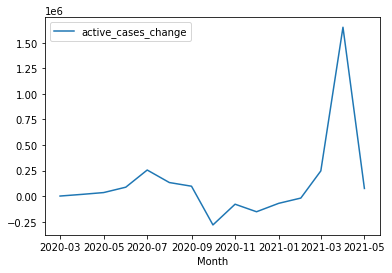

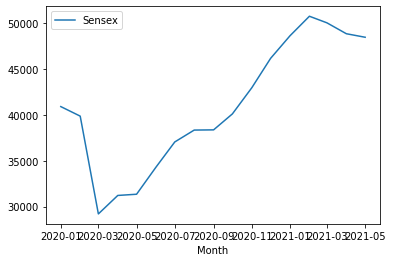

In [43]:

CZ_stock_df_2=CZ_temp_df.select([to_date("MonthYear","yyyy-MM").alias('DYM'),'Total_Confirmed_recov_deceas' ,'Avg_Sensex_Close']) \
.groupBy('DYM').agg({'Total_Confirmed_recov_deceas':'sum','Avg_Sensex_Close':'avg' }) \
.select(col('DYM'),col('avg(Avg_Sensex_Close)').alias('Sensex'),col('sum(Total_Confirmed_recov_deceas)').alias('active_cases_change')).orderBy('DYM')
p1=CZ_stock_df_2.toPandas().plot(x='DYM',y='active_cases_change',xlabel='Month')

p2=CZ_stock_df_2.toPandas().plot(x='DYM',y='Sensex',xlabel='Month')



### Correlation analysis
Indian stock market plummeted last year amid rising covid cases and nationwide lockdown. Sensex was at its minimum during March – April 2020 and slowly started rising upwards even when covid cases continued to rise. It continued to improve and reached its maximum in Feb 2021 when there were very less cases and most of the economy was open. Then due to effect of second wave, it started to drop again, however this time the drop is not as steep as first wave. The first steep downfall can be attributed to shock among people of lockdown and panic selling. As the grim covid situation continues to rise and forcing partial to total lockdown in major hit parts of the country, it will affect sensex adversely but its intensity will be dependent on various factors including covid cases, vaccination drive, digitalisation etc. 


In [44]:
CZ_temp.corr()

,Total_Confirmed_recov_deceas,Avg_sensex_volume,Avg_Sensex_Close
Total_Confirmed_recov_deceas,1.000000,-0.150014,0.130963
Avg_sensex_volume,-0.150014,1.000000,-0.489721
Avg_Sensex_Close,0.130963,-0.489721,1.000000


In [45]:
CZ_temp

,State,MonthYear,Total_Confirmed_recov_deceas,Avg_sensex_volume,Avg_Sensex_Close
0,Gujarat,2020-11,1101.0,21390.819672,42983.803377
1,Chhattisgarh,2021-01,-5325.0,17991.666667,48629.251136
2,Jammu and Kashmir,2020-06,380.0,24601.492537,34256.952687
3,Andaman and Nicobar Islands,2020-05,NaN,19900.000000,31443.380000
4,Uttar Pradesh,2021-04,170860.0,13139.283204,48876.480822
...,...,...,...,...,...
519,Delhi,2020-05,4525.0,28165.000000,31313.823500
520,Maharashtra,2020-06,25911.0,24440.963855,34270.564284
521,Karnataka,2021-02,-678.0,22056.695652,50782.385948
522,Arunachal Pradesh,2020-07,508.0,18671.590909,37332.321477


In [46]:

CZ_temp=CZ_temp.pivot('State','MonthYear','Total_Confirmed_recov_deceas')
CZ_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38 entries, nan to West Bengal
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   2020-01  0 non-null      float64
 1   2020-02  0 non-null      float64
 2   2020-03  8 non-null      float64
 3   2020-04  15 non-null     float64
 4   2020-05  23 non-null     float64
 5   2020-06  28 non-null     float64
 6   2020-07  33 non-null     float64
 7   2020-08  33 non-null     float64
 8   2020-09  33 non-null     float64
 9   2020-10  34 non-null     float64
 10  2020-11  34 non-null     float64
 11  2020-12  34 non-null     float64
 12  2021-01  31 non-null     float64
 13  2021-02  31 non-null     float64
 14  2021-03  29 non-null     float64
 15  2021-04  36 non-null     float64
 16  2021-05  34 non-null     float64
dtypes: float64(17)
memory usage: 5.3+ KB


In [47]:
CZ_temp

MonthYear,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05
State,,,,,,,,,,,,,,,,,
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Andaman and Nicobar Islands,NaN,NaN,NaN,NaN,NaN,NaN,218.0,94.0,-209.0,10.0,-42.0,-43.0,NaN,NaN,NaN,104.0,15.0
Andhra Pradesh,NaN,NaN,NaN,NaN,44.0,4708.0,50114.0,22499.0,-29940.0,-24737.0,-8111.0,-3384.0,-1151.0,-496.0,4017.0,75505.0,16419.0
Arunachal Pradesh,NaN,NaN,NaN,NaN,NaN,121.0,508.0,394.0,1448.0,-497.0,-633.0,-612.0,NaN,NaN,NaN,989.0,NaN
Assam,NaN,NaN,NaN,NaN,591.0,1265.0,5776.0,15158.0,13063.0,-15986.0,-4395.0,-13.0,-900.0,-173.0,181.0,16879.0,3509.0
Bihar,NaN,NaN,NaN,NaN,988.0,200.0,10839.0,-2655.0,-2713.0,-2810.0,-801.0,-276.0,-2495.0,-707.0,601.0,63892.0,485.0
Chandigarh,NaN,NaN,NaN,NaN,-30.0,-60.0,201.0,823.0,68.0,-857.0,452.0,-500.0,-101.0,160.0,1590.0,2712.0,578.0
Chhattisgarh,NaN,NaN,NaN,NaN,173.0,-101.0,1662.0,8636.0,11185.0,-4746.0,-460.0,-7239.0,-5325.0,-1474.0,15567.0,59925.0,4092.0
Dadra and Nagar Haveli and Daman and Diu,NaN,NaN,NaN,NaN,NaN,NaN,163.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1060.0,NaN


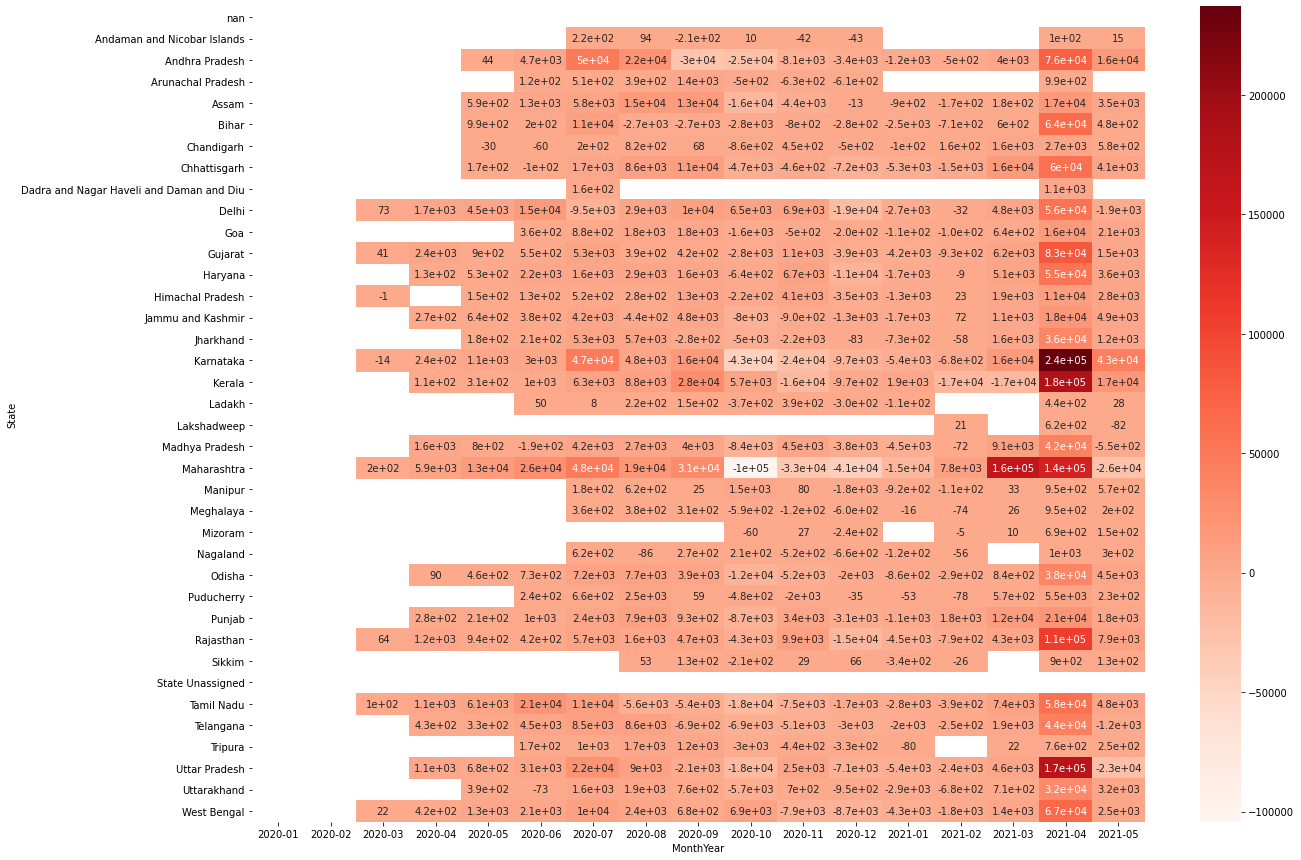

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
#,xticklabels='State',yticklabels='MonthYear'
# CZ_temp = CZ_temp[CZ_temp['State'] is not None]
plt.subplots(figsize=(20,15))
sns.heatmap(CZ_temp, annot=True,cmap="Reds")

### Heat Map analysis
Heat map displays covid cases with time for each state/UT. Red color gradient shows cases intensity across states and with progressing time

### ABC Analysis (Pareto) - Top States containing most of the Confirmed cases.


We are assessing latent catagories in our data, we first plot histogram of Confirmed Covid cases

In [49]:
CZ_districts_temp= SZ_districts.groupBy('State')\
                       .agg({'Confirmed':'sum','Recovered':'sum','Deceased':'sum'})\
                       .withColumn('TotalConfirmed',col('sum(Confirmed)'))\
                               .withColumn('TotalRecovered',col('sum(Recovered)'))\
                               .withColumn('TotalDeceased',col('sum(Deceased)'))\
                               .sort(col('TotalConfirmed').desc()).toPandas()
                               
         

**Data pattern after aggregating on State**

In [50]:
CZ_districts_temp

,State,sum(Recovered),sum(Deceased),sum(Confirmed),TotalConfirmed,TotalRecovered,TotalDeceased
0,Maharashtra,4105907.0,71411.0,4822888,4822888,4105907.0,71411.0
1,Kerala,1338973.0,5507.0,1701919,1701919,1338973.0,5507.0
2,Karnataka,1209892.0,16530.0,1690862,1690862,1209892.0,16530.0
3,Uttar Pradesh,1081498.0,13769.0,1368174,1368174,1081498.0,13769.0
4,Tamil Nadu,1108436.0,14589.0,1249285,1249285,1108436.0,14589.0
5,Delhi,1123896.0,17699.0,1232938,1232938,1123896.0,17699.0
6,Andhra Pradesh,1015913.0,8258.0,1184026,1184026,1015913.0,8258.0
7,West Bengal,765741.0,11727.0,898527,898527,765741.0,11727.0
8,Chhattisgarh,653518.0,9485.0,787478,787478,653518.0,9485.0
9,Rajasthan,465684.0,4826.0,668217,668217,465684.0,4826.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


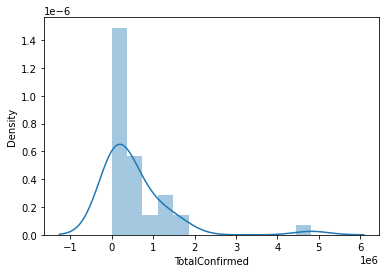

In [51]:
sns.distplot(CZ_districts_temp['TotalConfirmed'])

We observe there are visible separation in distribution, this infers that data distribution can be analysed categorically, hence we go ahead and plot Pareto graph

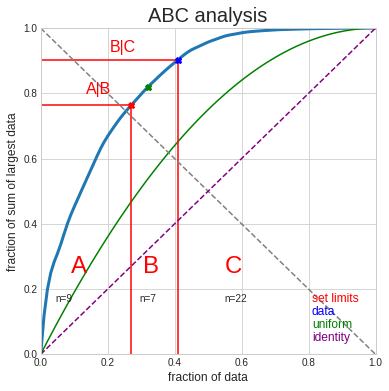

In [52]:
from abc_analysis import abc_analysis, abc_plot
abc = abc_analysis(CZ_districts_temp['TotalConfirmed'], True)

### ABC (Pareto) analysis

This analysis divides data into 3 categories A, B and C with A category being the most important in terms of effect on total outcome. In this particular analysis, we observe top states contributing to most of the covid cases. 

* Category A: Contains top 25% states/UT covering 75% of total infections
* Category B: contains 15% states/UT covering 10% of total infections
* Category C: contains 60% of rest of the states/UT covering 15% of total infections

This can be extremely helpful data in controlling covid spread. If proper lockdown measures, social distancing and other norms can be strictly controlled in these cases, the outbreak control could be better.

The table below highlights the states/UT in each of the 3 categories

From this analysis and table we observe that the worst 5 hit states/UT are:- Maharashtra, Kerala, Karnataka, Uttar Pradesh and Tamil Nadu


In [53]:
import inventorize3 as inv
data_abc= inv.ABC(CZ_districts_temp[['State','TotalConfirmed']])
data_abc = data_abc[pd.notnull(data_abc['State'])]
data_abc 
  

,State,TotalConfirmed,Percentage,comulative,Category
0,Maharashtra,4822888,0.233461,0.233461,A
1,Kerala,1701919,0.082384,0.315845,A
2,Karnataka,1690862,0.081849,0.397694,A
3,Uttar Pradesh,1368174,0.066229,0.463923,A
4,Tamil Nadu,1249285,0.060474,0.524397,A
5,Delhi,1232938,0.059683,0.584080,A
6,Andhra Pradesh,1184026,0.057315,0.641395,A
7,West Bengal,898527,0.043495,0.684890,A
8,Chhattisgarh,787478,0.038119,0.723009,A
9,Rajasthan,668217,0.032346,0.755355,A


Let us check the count of Categories

In [54]:
data_abc.Category.value_counts()

C    19
A    11
B     7
Name: Category, dtype: int64

### Statewise confirmed cases

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1668: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


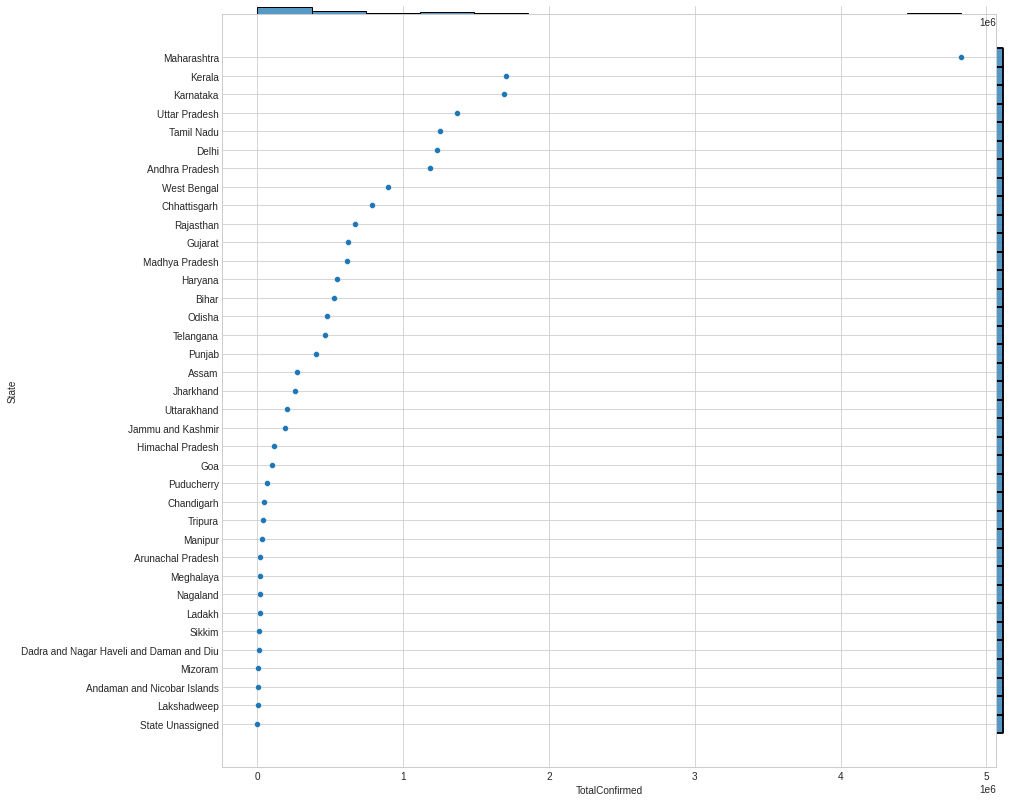

In [55]:

p=sns.jointplot(x="TotalConfirmed",y="State",data=data_abc,height=14,ratio=100,space=0,palette='coolwarm')
p

### Top 10 States by Confirmed cases

In [56]:
df_topstate_confirmed=data_abc.loc[data_abc['Category'] == 'A']
df_topstate_confirmed["State"]

0        Maharashtra
1             Kerala
2          Karnataka
3      Uttar Pradesh
4         Tamil Nadu
5              Delhi
6     Andhra Pradesh
7        West Bengal
8       Chhattisgarh
9          Rajasthan
10           Gujarat
Name: State, dtype: object

### Top 10 states by confirmed cases

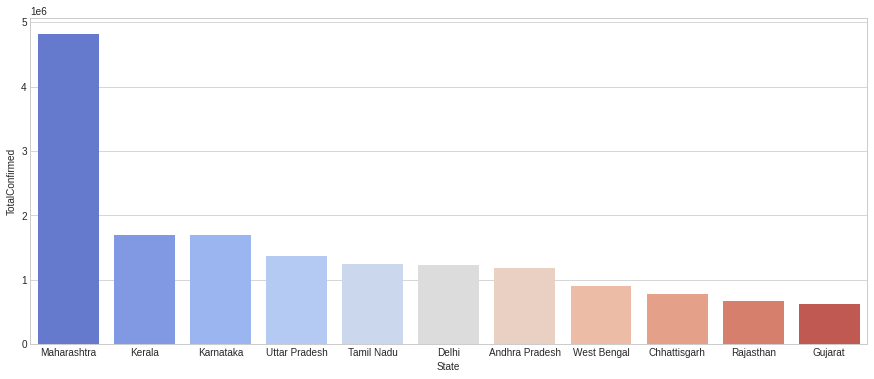

In [57]:
plt.figure(figsize= (15, 6 ))
sns.barplot(data = df_topstate_confirmed,
           x = 'State',
           y = 'TotalConfirmed',palette='coolwarm')

## **Cubes**

In [59]:
CZ_joined_data.na.drop()

DataFrame[Date: date, State: string, district: string, Confirmed: int, Recovered: int, Deceased: int, Sensex_Close: double, Sensex_Volume: double, Month: int, Year: int, Quarter: int, MonthYear: string, QuarterYear: string]

In [60]:
rcases_Cube = CZ_joined_data.cube( "State", "District", "Year", "Month").sum("Recovered").sort(col("State").desc(), col("Year").asc())

rcases_Cube.cache()
rcases_Cube.show()

+-----------+-----------------+----+-----+--------------+
|      State|         District|Year|Month|sum(Recovered)|
+-----------+-----------------+----+-----+--------------+
|West Bengal|             null|null| null|            86|
|West Bengal| Dakshin Dinajpur|null| null|          6543|
|West Bengal|       Alipurduar|null|    6|           120|
|West Bengal|Paschim Medinipur|null|    1|           427|
|West Bengal|   Uttar Dinajpur|null|    6|           194|
|West Bengal|          Bankura|null|    8|          1050|
|West Bengal|       Darjeeling|null|    7|           972|
|West Bengal|          Hooghly|null|    5|          1533|
|West Bengal|       Alipurduar|null|   10|          1208|
|West Bengal|  Purba Bardhaman|null|    7|           263|
|West Bengal|       Jalpaiguri|null|   12|          1552|
|West Bengal|North 24 Parganas|null| null|        114633|
|West Bengal|Paschim Medinipur|null|    2|           116|
|West Bengal|North 24 Parganas|null|   10|         16318|
|West Bengal|S

In [61]:
ccases_Cube = CZ_joined_data.cube( "State", "District", "Year", "Month").sum("Confirmed").sort(col("State").desc(), col("Year").asc())
ccases_Cube.cache()
ccases_Cube.show()

+-----------+-----------------+----+-----+--------------+
|      State|         District|Year|Month|sum(Confirmed)|
+-----------+-----------------+----+-----+--------------+
|West Bengal|             null|null| null|           467|
|West Bengal| Dakshin Dinajpur|null| null|          7208|
|West Bengal|       Alipurduar|null|    6|            96|
|West Bengal|Paschim Medinipur|null|    1|           209|
|West Bengal|   Uttar Dinajpur|null|    6|           122|
|West Bengal|          Bankura|null|    8|          1234|
|West Bengal|       Darjeeling|null|    7|          1202|
|West Bengal|          Hooghly|null|    5|          1840|
|West Bengal|       Alipurduar|null|   10|          1213|
|West Bengal|  Purba Bardhaman|null|    7|           513|
|West Bengal|       Jalpaiguri|null|   12|          1420|
|West Bengal|North 24 Parganas|null| null|        131036|
|West Bengal|Paschim Medinipur|null|    2|            48|
|West Bengal|North 24 Parganas|null|   10|         16796|
|West Bengal|S

#### Grouping Sets

In [62]:
CZ_joined_data.columns

['Date',
 'State',
 'district',
 'Confirmed',
 'Recovered',
 'Deceased',
 'Sensex_Close',
 'Sensex_Volume',
 'Month',
 'Year',
 'Quarter',
 'MonthYear',
 'QuarterYear']

In [63]:
from pyspark.sql.functions import *

CZ_joined_data.createOrReplaceTempView("CZ_joined_dataTable")

CZ_groupingset = spark.sql("""SELECT  Year ,State, district, sum(Confirmed)
                                    FROM CZ_joined_dataTable 
                                    GROUP BY district, State, Year 
                                    GROUPING SETS((district),
                                                  (district, State),  
                                                  (district, Year))""")


In [64]:
CZ_groupingset.show()

+----+-------------+---------------+--------------+
|Year|        State|       district|sum(Confirmed)|
+----+-------------+---------------+--------------+
|null|         null|       Rayagada|          7130|
|null|         null|     Kushinagar|          6854|
|2020|         null|         Morena|          2168|
|null|       Odisha|         Jajpur|         10983|
|null|    Meghalaya|West Garo Hills|          1297|
|null|       Odisha|      Kandhamal|          4680|
|null|         null|          Dumka|          2494|
|null|Uttar Pradesh|         Rampur|          6045|
|2021|         null|    Bulandshahr|          4138|
|null|  Maharashtra|         Sangli|         57756|
|null|        Assam|      Dibrugarh|         10331|
|null|       Odisha|   Nabarangapur|          7472|
|2021|         null|       Siddipet|          3262|
|null|Uttar Pradesh|        Bhadohi|          4073|
|2021|         null|          Hisar|         10860|
|null|         null|        CHENNAI|            17|
|null|      

# Conclusion and Further Analysis

* We have concluded that Covid-19 pandemic and lockdown had significant impact on Indian stock market. 
* There is a negative correlation between the two as expected. 
* We also notice that even with deadlier second wave, stock markets have so far held up. 
* However, if the situation continues to worsen, it can have adverse impact on stock market. 

**Scope for further analysis**

To predict how stock market will behave, we need more data from wave 2 and can possibly build a prediction model to forecast. 

Impact of covid on precious metals, large mid and small cap companies 
separately can also be studied.

<hr/>

# References



1.   https://pdf.sciencedirectassets.com/280203/1-s2.0-S1877050919X00162/1-s2.0-S1877050919317260/main.pdf
2.   https://www.databench.eu/wp-content/uploads/2020/03/tutorial_on_benchmarking_big_data_analytics_systems.pdf
3.   https://amplab.cs.berkeley.edu/benchmark/
4.   https://www.researchgate.net/publication/318664623_Benchmarking_Big_Data_Systems_A_Review
5.   https://stackoverflow.com/a/46101836/1664784


